# Textual Variation Analysis for 'Conditions' Columns

This analysis builds upon ealier iterations using [textAnalysis.py](https://github.com/UCSB-AMPLab/sondondo/blob/e3d7781/project_code/textAnalysis.py) and [textualAnalysis.py](https://github.com/UCSB-AMPLab/sondondo/blob/6fd3812/project_code/textualAnalysis.py) which led to the creation of the current [conditionMapping.json](https://github.com/UCSB-AMPLab/sondondo/blob/c200723/data/mappings/conditionMapping.json).

The goal of this analysis is to examine textual variation and overlapping categories within the "conditions" columns across the cleaned datasets (`data/clean/bautismos_clean.csv`, `data/clean/matrimonios_clean.csv`, and `data/clean/defunciones_clean.csv`). This helps to evaluate how a reduced and harmonized mapping contributes to a more consistent and maneageable classification scheme.


## Strategy for Creating `conditionMapping.json`

The main objective was to reduce textual variation in the "conditions" columns without inadvertently losing important information. The process involved the following steps:

1. Define three main categories of "conditions":
   - Legitimacy status: Wheter the child was born within a legitimate marriage.
   - Marital status: Wheter a persona was married, divorced, or widowed at the time of the event.
   - Social condition: Labels used by the authority recording the event to mark social origin or perceived status (e.g., "indigena", "mestizo").
2. Run TF-IDF analysis across all "conditions" columns from the raw datasets to identify the most frequent and distinctive keywords in each group.
   - Results can be found in [main@e3d7781/logs/textanalysis.log](https://github.com/UCSB-AMPLab/sondondo/blob/e3d7781/logs/textanalysis.log)
3.  Manually curate mapping from the top-ranked terms for each category. The following criteria guided the normalization process:
    - Remove diacritics and accents.
    - Convert all gendered terms to their masculine form.
    - Use singular rather than plural forms.
    - Expand abbreviations to full terms.
    - Consolidate synonyms into the most commonly used or historically accurate term, e.g., "natural" mapped to "indio".

## Set the Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

from utils.LoggerHandler import setup_logger

logger = setup_logger("termExtraction")

In [2]:
dataframes_paths = {
    "bautismos": {
        "csv_file": "../data/clean/bautismos_clean.csv"
    },
    "entierros": {
        "csv_file": "../data/clean/entierros_clean.csv"
    },
    "matrimonios": {
        "csv_file": "../data/clean/matrimonios_clean.csv"
    }
}

with open('../data/mappings/conditionMapping.json', 'r', encoding='utf-8') as f:
    condition_mappings = json.load(f)

existing_mappings = {
    "legitimacy_status": list(condition_mappings["attribute_mappings"]["legitimacy_status"].keys()),
    "social_condition": list(condition_mappings["attribute_mappings"]["social_condition"].keys()),
    "marital_status": list(condition_mappings["attribute_mappings"]["marital_status"].keys())
}


## Pre-Normalization Analysis

To accurately assess the effectiveness of the mapping, we performed a series of statistical analyses on the cleaned datasets before normalization. This establishes a baseline for measuring the impact of harmonization.


### Textual Variation Extraction

These methods extract textual variations from the "conditions" columns using a regex pattern that matches the defined categories. 

In [3]:
def extract_textual_variations_from_columns(column_pattern, dataframes_paths, min_frequency: int = 1) -> dict:
    """
    Extract all textual variations from columns matching a pattern.
    This reveals how conditions were expressed in historical documents,
    including mixed categories (e.g., marital status + age descriptors).
    
    Args:
        column_pattern: Regex pattern to match column names
        min_frequency: Minimum frequency for a term to be included
        
    Returns:
        Dictionary with term frequencies and contextual metadata
    """
    term_data = {}

    for dataset, info in dataframes_paths.items():
        logger.info(f"Extracting textual variations from {dataset}...")
        csv_path = info["csv_file"]

        df = pd.read_csv(csv_path)

        # Find matching columns
        if isinstance(column_pattern, str):
            pattern = re.compile(column_pattern)
        else:
            pattern = column_pattern
            
        matching_columns = [col for col in df.columns if pattern.search(col)]
        logger.info(f"Columns found: {matching_columns}")

        if not matching_columns:
            continue
        
        # Extract all textual variations
        for col in matching_columns:
            logger.info(f"Processing column: {col}")
            
            # basic preprocessing
            values = df[col].dropna().astype(str)
            values = values[values != 'nan']
            values = values[values.str.strip() != '']
            
            cleaned_values = values.str.lower().str.strip()

            logger.info(f"Found {len(cleaned_values)} non-empty entries")

            # Count occurrences
            value_counts = cleaned_values.value_counts()
            
            for term, count in value_counts.items():
                if term not in term_data:
                    term_data[term] = {
                        'frequency': 0, 
                        'columns': set(), 
                        'datasets': set(),
                        'raw_variations': set()
                    }
                
                term_data[term]['frequency'] += count
                term_data[term]['columns'].add(col)
                term_data[term]['datasets'].add(dataset)
                
                original_values = values[cleaned_values == term]
                term_data[term]['raw_variations'].update(original_values.tolist())

    # Filter by frequency
    filtered_terms = {}
    for term, data in term_data.items():
        if data['frequency'] >= min_frequency:
            filtered_terms[term] = {
                'frequency': data['frequency'],
                'columns': list(data['columns']),
                'datasets': list(data['datasets']),
                'raw_variations': list(data['raw_variations'])
            }
    
    return filtered_terms

In [4]:
# Categories Data

legitimacy_variations = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*legitimacy_status.*"),
    min_frequency=1,
    dataframes_paths=dataframes_paths
)

social_variations = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*social_condition.*"),
    min_frequency=1,
    dataframes_paths=dataframes_paths
)

marital_variations = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*marital_status.*"),
    min_frequency=1,
    dataframes_paths=dataframes_paths
)


In [5]:
categories_data = {
    'legitimacy_status': (legitimacy_variations, existing_mappings["legitimacy_status"]),
    'social_condition': (social_variations, existing_mappings["social_condition"]),
    'marital_status': (marital_variations, existing_mappings["marital_status"])
}

### Results of the Exploratory Analysis

We performed a frequency count of the terms found in the "conditions" columns, grouping them by their main categories. The following results summarize the number of unique terms and their total frequency of appearance in the dataset:

In [6]:
stats = {}

for category, (terms_dict, mappings) in categories_data.items():
    frequencies = [info['frequency'] for info in terms_dict.values()]
    stats[category] = {
        'frequencies': frequencies,
        'total_terms': len(frequencies),
        'total_frequency': sum(frequencies)
    }

stats_df = pd.DataFrame(stats).T.sort_values(by='total_frequency', ascending=False).reset_index().rename(columns={'index': 'category'})
stats_df

,category,frequencies,total_terms,total_frequency
0,social_condition,"[1382, 332, 29, 14, 21, 8, 33, 10, 109, 6, 6, ...",1183,10883
1,legitimacy_status,"[996, 917, 1495, 1366, 521, 428, 383, 350, 118...",314,10265
2,marital_status,"[400, 247, 406, 1389, 1321, 368, 24, 24, 18, 1...",34,4254


The data shows that the social condition category has the highest number of unique terms (1183). This suggests that many of the terms under social condition appear only once or a few times, indicating high textual variation and inconsistency — likely due to diverse wording choices by different scribes over time, as well as inconsistencies introduced during transcription.

In contrast, the marital status category is significantly more standardized, with only 34 unique terms used across 4,254 entries. This low variation points to a more consistent vocabulary and higher likelihood of successful harmonization.

To further quantify this, we computed the average frequency per term, which helps identify how often terms are reused — a proxy for redundancy and consistency.

In [7]:
stats_df['avg_frequency_per_term'] = stats_df['total_frequency'] / stats_df['total_terms']
stats_df['avg_frequency_per_term'] = stats_df['avg_frequency_per_term'].astype(float).round(2)
stats_df

,category,frequencies,total_terms,total_frequency,avg_frequency_per_term
0,social_condition,"[1382, 332, 29, 14, 21, 8, 33, 10, 109, 6, 6, ...",1183,10883,9.20
1,legitimacy_status,"[996, 917, 1495, 1366, 521, 428, 383, 350, 118...",314,10265,32.69
2,marital_status,"[400, 247, 406, 1389, 1321, 368, 24, 24, 18, 1...",34,4254,125.12


As shown above:

- Social condition has the lowest average frequency per term (~9.20), confirming high fragmentation and the presence of long-tail entries that may be semantically similar but textually distinct.

- Marital status has the highest reuse rate (~125 per term), suggesting a more constrained vocabulary and consistent usage patterns.

- Legitimacy status sits in between, with moderate variation and moderate reuse.

While all three categories benefit from textual normalization, social condition stands out as requiring special attention. Its high number of unique, low-frequency terms suggests significant noise and ambiguity that can hinder downstream analysis unless harmonized. The average frequency metric supports this interpretation and can serve as a quantifiable justification for the harmonization strategy applied in subsequent steps.

### Frequency Distribution Plots

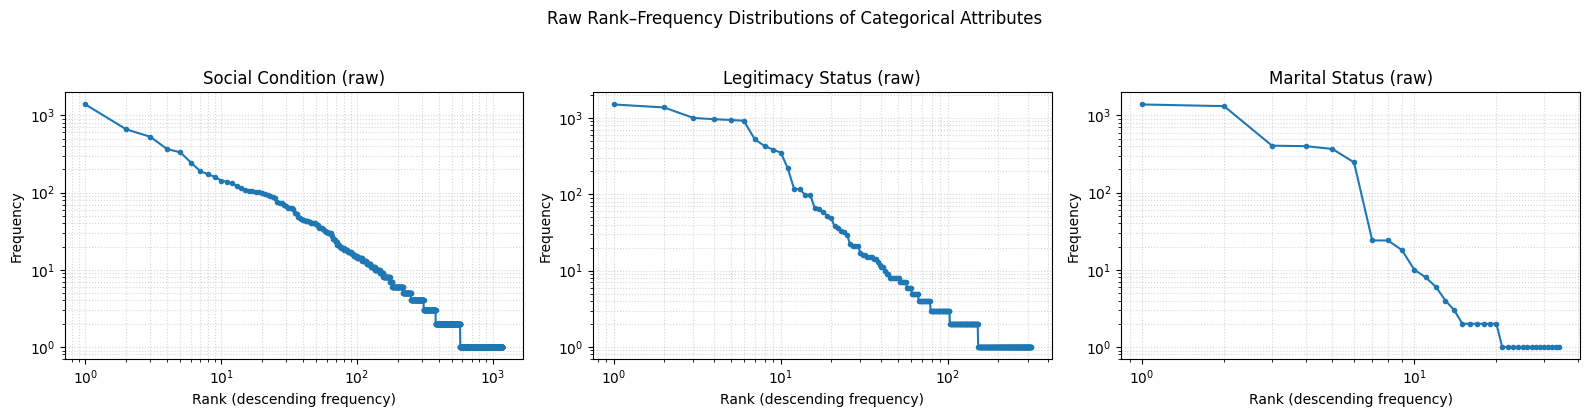

In [8]:
cats   = ['social_condition', 'legitimacy_status', 'marital_status']
titles = ['Social Condition (raw)', 'Legitimacy Status (raw)', 'Marital Status (raw)']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, (cat, title) in zip(axes, zip(cats, titles)):
    
    # get the list of frequencies (already sorted? if not sorted, sort descending)
    freqs = stats_df.loc[stats_df['category'] == cat, 'frequencies'].iloc[0]
    
    # convert to numpy array and sort descending
    freqs = np.array(freqs)
    freqs = np.sort(freqs)[::-1]
    
    # compute ranks
    ranks = np.arange(1, len(freqs) + 1)
    
    # plot rank–frequency on log–log scale
    ax.loglog(ranks, freqs, marker='o', linestyle='-', markersize=3)
    
    ax.set_title(title)
    ax.set_xlabel("Rank (descending frequency)")
    ax.set_ylabel("Frequency")
    
    ax.grid(True, which='both', linestyle=':', alpha=0.5)

plt.suptitle("Raw Rank–Frequency Distributions of Categorical Attributes", y=1.03)
plt.tight_layout()
plt.show()

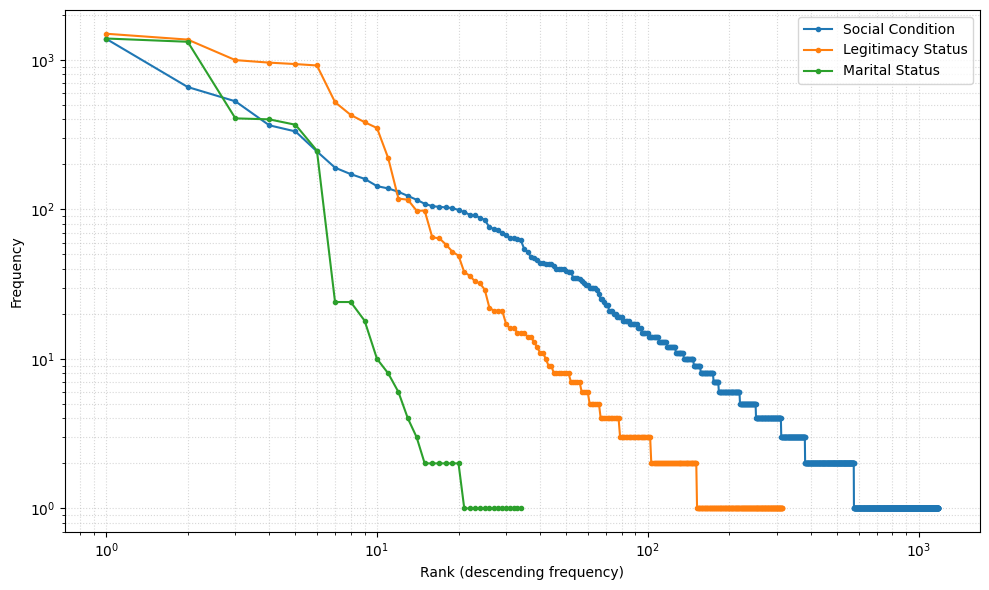

In [9]:
## All lines in a single plot
cats   = ['social_condition', 'legitimacy_status', 'marital_status']
titles = ['Social Condition', 'Legitimacy Status', 'Marital Status']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for cat, title in zip(cats, titles):
    # get the list of frequencies
    freqs = stats_df.loc[stats_df['category'] == cat, 'frequencies'].iloc[0]
    
    # convert to numpy array and sort descending
    freqs = np.array(freqs)
    freqs = np.sort(freqs)[::-1]

    # compute ranks
    ranks = np.arange(1, len(freqs) + 1)
    
    # plot rank–frequency on log–log scale
    ax.loglog(ranks, freqs, marker='o', linestyle='-', markersize=3, label=title)

#ax.set_title("Raw Rank–Frequency Distributions of Categorical Attributes")
ax.set_xlabel("Rank (descending frequency)")
ax.set_ylabel("Frequency")
ax.legend()
ax.grid(True, which='both', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()
    
    

### Coefficient of Variation

The coefficient of variation (CV) measures how much variability exists relative to the average value. In our case, we compute the CV based on the frequency distribution of unique "conditions" entries. A lower CV indicates more consistent term usage across the dataset.

In [10]:
from utils import StatsMethods

In [11]:
stats_df['cv'] = stats_df.apply(lambda row: StatsMethods.cv(row['frequencies'], rounding=2), axis=1)
stats_df

,category,frequencies,total_terms,total_frequency,avg_frequency_per_term,cv
0,social_condition,"[1382, 332, 29, 14, 21, 8, 33, 10, 109, 6, 6, ...",1183,10883,9.20,5.68
1,legitimacy_status,"[996, 917, 1495, 1366, 521, 428, 383, 350, 118...",314,10265,32.69,4.96
2,marital_status,"[400, 247, 406, 1389, 1321, 368, 24, 24, 18, 1...",34,4254,125.12,2.66


### Shannon Entropy

Shannon entropy quantifies the uncertainty or randomness in a set of data. Social condition has the highest entropy (H) and normalized entropy (Normalized_H), demonstrating the high level of fragmentation in this category. Legitimacy and marital status show lower entropy levels, but we expect that normalization will reduce entropy across all categories, leading to more consistent usage patterns.

In [12]:
stats_df[['H', 'H_max', 'Normalized_H', 'Redundancy']] = stats_df.apply(
    lambda row: StatsMethods.shannon_entropy(row['frequencies'], rounding=2),
    axis=1, result_type='expand'
)
stats_df[['cv', 'H', 'H_max', 'Normalized_H', 'Redundancy']]

,cv,H,H_max,Normalized_H,Redundancy
0,5.68,7.29,10.21,0.71,0.29
1,4.96,4.43,8.29,0.53,0.47
2,2.66,2.50,5.09,0.49,0.51


### Zipf Distribution

Zipf's law describes the frequency of terms in a language, where a few terms are very common while many others are rare. A Zipfian distribution indicates that a small number of terms dominate usage, while many others are used infrequently. We visualize the empirical rank-frequency distribution against the theoretical Zipf curve to assess how closely the data conforms to this pattern before normalization.

In [13]:
stats_df['zipf_distribution'] = stats_df.apply(
    lambda row: StatsMethods.zipf_distribution(row['frequencies'], rounding=2),
    axis=1
)

stats_df['empirical_ranks'] = stats_df.apply(
    lambda row: StatsMethods.empirical_rank_freq(row['frequencies'], normalize=True, rounding=2),
    axis=1
)

stats_df[['cv', 'H', 'H_max', 'Normalized_H', 'Redundancy', 'zipf_distribution', 'empirical_ranks']]

,cv,H,H_max,Normalized_H,Redundancy,zipf_distribution,empirical_ranks
0,5.68,7.29,10.21,0.71,0.29,"[0.13, 0.07, 0.04, 0.03, 0.03, 0.02, 0.02, 0.0...","[0.13, 0.06, 0.05, 0.03, 0.03, 0.02, 0.02, 0.0..."
1,4.96,4.43,8.29,0.53,0.47,"[0.16, 0.08, 0.05, 0.04, 0.03, 0.03, 0.02, 0.0...","[0.15, 0.13, 0.1, 0.09, 0.09, 0.09, 0.05, 0.04..."
2,2.66,2.50,5.09,0.49,0.51,"[0.24, 0.12, 0.08, 0.06, 0.05, 0.04, 0.03, 0.0...","[0.33, 0.31, 0.1, 0.09, 0.09, 0.06, 0.01, 0.01..."


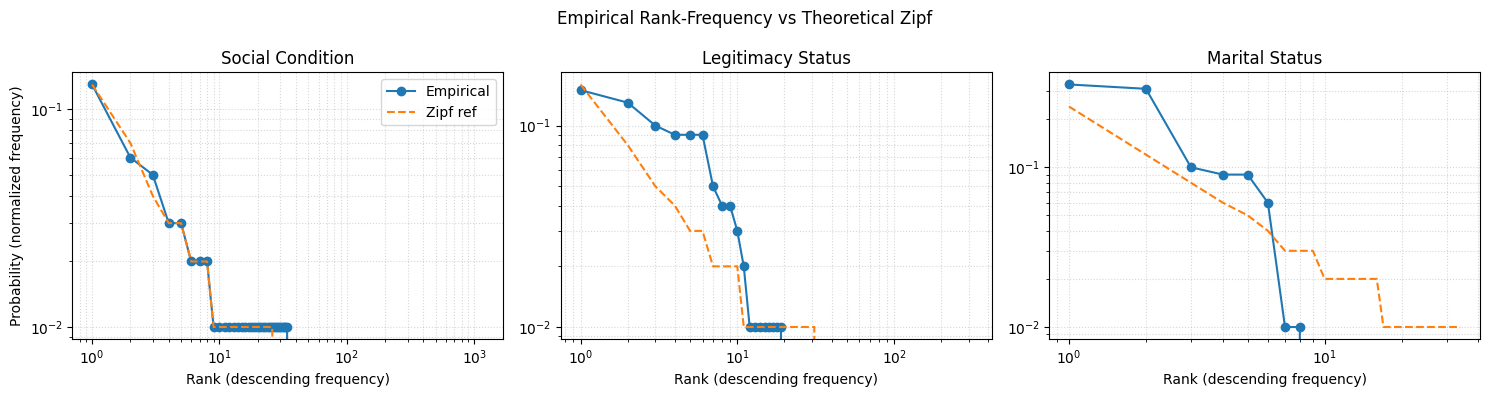

In [14]:
def get_series(df, cat, col):
    return df.loc[df['category'] == cat, col].iloc[0]

cats   = ['social_condition','legitimacy_status','marital_status']
titles = ['Social Condition','Legitimacy Status','Marital Status']

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, cat, title in zip(axes, cats, titles):
    z_before = get_series(stats_df, cat, 'zipf_distribution')
    e_before = get_series(stats_df, cat, 'empirical_ranks')


    # x = ranks (start at 1)
    xb = np.arange(1, len(e_before) + 1)

    # empirical 
    ax.loglog(xb, e_before, marker='o', linestyle='-',  label='Empirical')

    # theoretical Zipf  (dashed)
    ax.loglog(xb, z_before, linestyle='--', label='Zipf ref')

    ax.set_title(title)
    ax.set_xlabel("Rank (descending frequency)")
    ax.grid(True, which='both', linestyle=':', alpha=0.5)

axes[0].set_ylabel("Probability (normalized frequency)")
axes[0].legend() 
plt.suptitle("Empirical Rank-Frequency vs Theoretical Zipf")
plt.tight_layout()
plt.show()

## Normalization

Our normalization strategy is designed to address the textual variation, redundancy, high entropy, and category mixing present in the “conditions” columns. The label “condition” was ambiguous even for parish priests and local officials, leading to inconsistent application across records. Without a standardized vocabulary or a consistent method for disambiguating terms, social, marital, and legitimacy-related descriptors appear intermingled in the same fields.

To resolve this, we developed the `InferCondition.py` module, which can extract specific attributes from any “conditions” column, regardless of the category in which they were recorded. For example, `extract_marital_status` can be applied to a `social_condition` column to recover marital status terms that were incorrectly placed there. When applied to the correct category, these extractors significantly reduce variability.

At its core, the module implements the AttributeNormalizer class, which:

- Loads predefined mapping dictionaries for social condition, legitimacy status, and marital status.
- Applies a multi-stage harmonization process:
    - Case-insensitive exact match (checks if the term already matches a target form).
    - Word-level match (matches any single token to the mapping).
    - Substring match (captures longer phrases containing mapped terms).
    - Fuzzy match (using RapidFuzz with a configurable threshold).
- Logs unmapped values for later review.
- Provides convenience methods to extract all attributes from a column or harmonize multiple columns in one pass.
- Includes a function to extract unmapped tokens, removing all known mapped values and leaving residual, potentially meaningful text for further analysis.

This normalization is a foundational step in preparing the dataset for probabilistic record linkage, as it reduces noise, improves consistency, and aligns variant expressions to a controlled vocabulary without discarding historically meaningful distinctions.

> This evaluation measures the effectiveness of the mapping only when applied to the correct category. It does not yet account for misfiled attributes across categories at the individual record level. A more comprehensive parsing and normalization process — applied directly to individual persona records — will be implemented in subsequent steps.

In [15]:
from actions.generators import InferCondition

In [16]:
def normalize_textual_variations_from_columns(dataframes_paths, mapping_file, threshold=80):
    """
    Normalize textual variations in multiple columns based on a mapping file.

    Args:
        column_pattern: Regex pattern to match column names
        mapping_file: Path to the JSON mapping file
        threshold: Level of fuzziness for matching terms (higher values are more strict)
    """

    inferer = InferCondition.AttributeNormalizer(mapping_file=mapping_file, fuzzy_threshold=threshold)

    for dataset, info in dataframes_paths.items():
        logger.info(f"Normalizing ALL categories in {dataset} (single pass)...")
        df = pd.read_csv(info["csv_file"])

        social_cols = [c for c in df.columns if c.lower().endswith("_social_condition") or c.lower().endswith("_condition")]
        for col in social_cols:
            logger.info(f"Normalizing SOCIAL column: {col}")
            df[col] = inferer.extract_social_condition(df[col])

        legitimacy_cols = [c for c in df.columns if c.lower().endswith("_legitimacy_status")]
        for col in legitimacy_cols:
            logger.info(f"Normalizing LEGITIMACY column: {col}")
            df[col] = inferer.extract_legitimacy_status(df[col])

        marital_cols = [c for c in df.columns if c.lower().endswith("_marital_status")]
        for col in marital_cols:
            logger.info(f"Normalizing MARITAL column: {col}")
            df[col] = inferer.extract_marital_status(df[col])

        df.to_csv(f"../data/interim/{dataset}_normalized.csv", index=False)
    logger.info("Normalization complete.")


In [17]:
normalize_textual_variations_from_columns(
    dataframes_paths=dataframes_paths,
    mapping_file=condition_mappings,
    threshold=80,
)



In [18]:
normalize_dataframes_paths = {
    "bautismos": {
        "csv_file": "../data/interim/bautismos_normalized.csv"
    },
    "entierros": {
        "csv_file": "../data/interim/entierros_normalized.csv"
    },
    "matrimonios": {
        "csv_file": "../data/interim/matrimonios_normalized.csv"
    }
}

In [19]:
legitimacy_variations_normalized = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*legitimacy_status.*"),
    min_frequency=1,
    dataframes_paths=normalize_dataframes_paths
)

social_variations_normalized = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*social_condition.*"),
    min_frequency=1,
    dataframes_paths=normalize_dataframes_paths
)

marital_variations_normalized = extract_textual_variations_from_columns(
    column_pattern=re.compile(r".*marital_status.*"),
    min_frequency=1,
    dataframes_paths=normalize_dataframes_paths
)


In [20]:
categories_data_normalized = {
    'legitimacy_status': (legitimacy_variations_normalized, existing_mappings["legitimacy_status"]),
    'social_condition': (social_variations_normalized, existing_mappings["social_condition"]),
    'marital_status': (marital_variations_normalized, existing_mappings["marital_status"])
}

In [21]:
stats_normalized = {}
for category, (terms_dict, mappings) in categories_data_normalized.items():
    frequencies = [info['frequency'] for info in terms_dict.values()]
    stats_normalized[category] = {
        'frequencies': frequencies,
        'total_terms': len(frequencies),
        'total_frequency': sum(frequencies)
    }
stats_normalized_df = pd.DataFrame(stats_normalized).T.sort_values(by='total_frequency', ascending=False).reset_index().rename(columns={'index': 'category'})
stats_normalized_df

,category,frequencies,total_terms,total_frequency
0,legitimacy_status,"[8925, 1278]",2,10203
1,social_condition,"[1663, 902, 43, 158, 5443, 331, 941]",7,9481
2,marital_status,"[692, 777, 2715]",3,4184


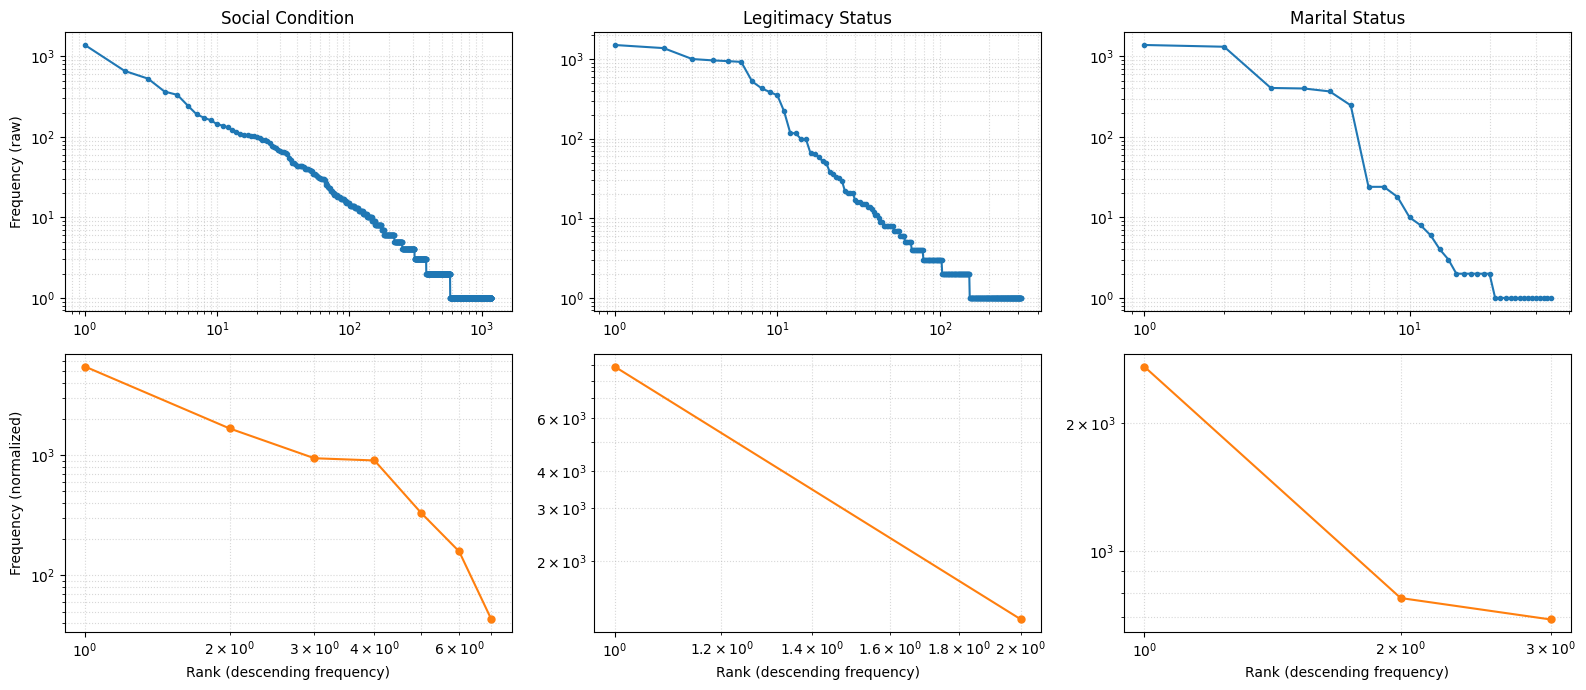

In [22]:
cats   = ['social_condition', 'legitimacy_status', 'marital_status']
titles = ['Social Condition', 'Legitimacy Status', 'Marital Status']

fig, axes = plt.subplots(2, 3, figsize=(16, 7))

# ---- ROW 1: RAW ----
for ax, cat, title in zip(axes[0], cats, titles):
    
    # extract raw frequencies list
    freqs_raw = stats_df.loc[stats_df['category'] == cat, 'frequencies'].iloc[0]
    
    # sort descending
    freqs_raw = np.sort(np.array(freqs_raw))[::-1]
    ranks_raw = np.arange(1, len(freqs_raw) + 1)
    
    ax.loglog(ranks_raw, freqs_raw, marker='o', linestyle='-', markersize=3)
    ax.set_title(f"{title}")
    ax.grid(True, which='both', linestyle=':', alpha=0.5)

axes[0,0].set_ylabel("Frequency (raw)")

# ---- ROW 2: NORMALIZED ----
for ax, cat, title in zip(axes[1], cats, titles):
    
    # extract cleaned frequencies list
    freqs_norm = stats_normalized_df.loc[
        stats_normalized_df['category'] == cat, 'frequencies'
    ].iloc[0]
    
    freqs_norm = np.sort(np.array(freqs_norm))[::-1]
    ranks_norm = np.arange(1, len(freqs_norm) + 1)
    
    ax.loglog(ranks_norm, freqs_norm, marker='o', linestyle='-', markersize=5, color='C1')
    ax.set_xlabel("Rank (descending frequency)")
    ax.grid(True, which='both', linestyle=':', alpha=0.5)

axes[1,0].set_ylabel("Frequency (normalized)")

plt.tight_layout()
plt.show()

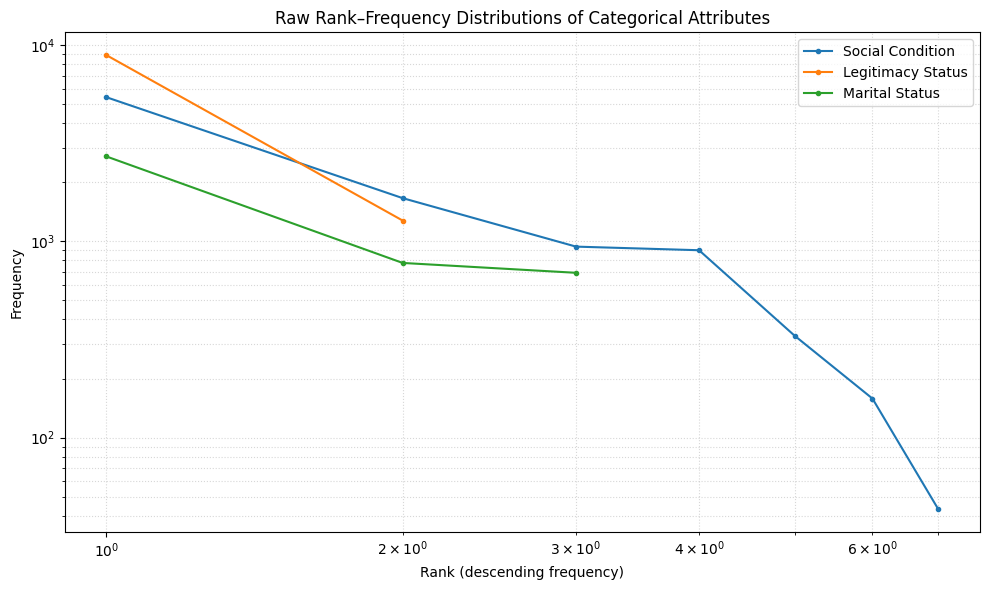

In [23]:
cats   = ['social_condition', 'legitimacy_status', 'marital_status']
titles = ['Social Condition', 'Legitimacy Status', 'Marital Status']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for cat, title in zip(cats, titles):
    # get the list of frequencies
    freqs = stats_normalized_df.loc[stats_normalized_df['category'] == cat, 'frequencies'].iloc[0]
    
    # convert to numpy array and sort descending
    freqs = np.array(freqs)
    freqs = np.sort(freqs)[::-1]
    
    # compute ranks
    ranks = np.arange(1, len(freqs) + 1)
    
    # plot rank–frequency on log–log scale
    ax.loglog(ranks, freqs, marker='o', linestyle='-', markersize=3, label=title)

ax.set_title("Raw Rank–Frequency Distributions of Categorical Attributes")
ax.set_xlabel("Rank (descending frequency)")
ax.set_ylabel("Frequency")
ax.legend()
ax.grid(True, which='both', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

## Post-Normalization Analysis

### Information Retention

After applying the normalization process, we assess its effectiveness by comparing key metrics before and after harmonization. This analysis evaluates information retention, consistency improvements, and the impact on distributional properties.

At first glance, the results show that the implementation successfully reduced dimensionality with minimal loss of information. Social condition—the most fragmented category—was reduced to just 7 unique terms, with only a 6.25% decrease in total frequency. Considering that the algorithm is designed to return `None` when no match is found, this reduction is both expected and encouraging, indicating that the normalization process retained most of the original data while greatly improving consistency.

In [24]:
clean_data = stats_df['total_frequency'].astype(float)
clean_data_normalized = stats_normalized_df['total_frequency'].astype(float)

# percentage of information lost
percentage_lost = pd.DataFrame({
    'category': stats_df['category'],
    'percentage_lost': ((clean_data - clean_data_normalized) / clean_data * 100).round(2)
})
percentage_lost

,category,percentage_lost
0,social_condition,6.25
1,legitimacy_status,7.64
2,marital_status,1.65


### Coefficient of Variation After Normalization

The coefficient of variation (CV) analysis confirms a substantial reduction in dispersion across categories after normalization. For legitimacy status, CV dropped from 4.96 to 1.06; for social condition, from 5.68 to 1.39; and for marital status, from 2.66 to 0.82. This indicates that the normalized categories are considerably more homogeneous, reducing variability while preserving most of the original data volume.

In [25]:
stats_normalized_df['cv'] = stats_normalized_df.apply(lambda row: StatsMethods.cv(row['frequencies'], rounding=2), axis=1)

stats_normalized_df

,category,frequencies,total_terms,total_frequency,cv
0,legitimacy_status,"[8925, 1278]",2,10203,1.06
1,social_condition,"[1663, 902, 43, 158, 5443, 331, 941]",7,9481,1.39
2,marital_status,"[692, 777, 2715]",3,4184,0.82


In [26]:
cv_comparison = pd.DataFrame({
    'category': stats_df['category'],
    'cv_before': stats_df['cv'],
    'cv_after': stats_normalized_df['cv']
})
cv_comparison

,category,cv_before,cv_after
0,social_condition,5.68,1.06
1,legitimacy_status,4.96,1.39
2,marital_status,2.66,0.82


### Shannon Entropy After Normalization

Shannon entropy analysis reveals improved distributional properties after normalization. While entropy shows a reduction in unpredictability overall, the normalized entropy for marital status increased from 0.49 to 0.81, indicating that the relative balance among categories has improved substantially. These results demonstrate that the mapping not only improved category balance but also reduced the clutter and fragmentation in the "conditions" columns.

In [27]:
stats_normalized_df[['H', 'H_max', 'Normalized_H', 'Redundancy']] = stats_normalized_df.apply(
    lambda row: StatsMethods.shannon_entropy(row['frequencies'], rounding=2),
    axis=1, result_type='expand'
)
stats_normalized_df[['cv', 'H', 'H_max', 'Normalized_H', 'Redundancy']]

,cv,H,H_max,Normalized_H,Redundancy
0,1.06,0.54,1.00,0.54,0.46
1,1.39,1.86,2.81,0.66,0.34
2,0.82,1.29,1.58,0.81,0.19


In [28]:
entropy_comparison = pd.DataFrame({
    'category': stats_df['category'],
    'H_before': stats_df['H'],
    'H_after': stats_normalized_df['H'],
    'H_max_before': stats_df['H_max'],
    'H_max_after': stats_normalized_df['H_max'],
    'Normalized_H_before': stats_df['Normalized_H'],
    'Normalized_H_after': stats_normalized_df['Normalized_H'],
    'Redundancy_before': stats_df['Redundancy'],
    'Redundancy_after': stats_normalized_df['Redundancy']
})
entropy_comparison

,category,H_before,H_after,H_max_before,H_max_after,Normalized_H_before,Normalized_H_after,Redundancy_before,Redundancy_after
0,social_condition,7.29,0.54,10.21,1.00,0.71,0.54,0.29,0.46
1,legitimacy_status,4.43,1.86,8.29,2.81,0.53,0.66,0.47,0.34
2,marital_status,2.50,1.29,5.09,1.58,0.49,0.81,0.51,0.19


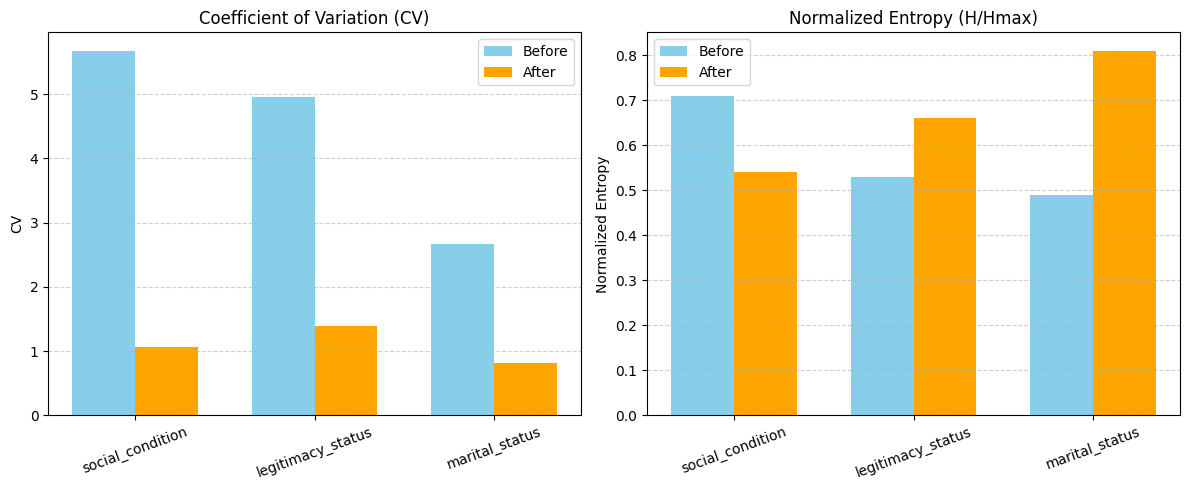

In [29]:
categories = stats_df['category'].tolist()

cv_before = stats_df['cv']
cv_after = stats_normalized_df['cv']

nh_before = stats_df['Normalized_H']
nh_after = stats_normalized_df['Normalized_H']

x = np.arange(len(categories))
width = 0.35 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot CV
axes[0].bar(x - width/2, cv_before, width, label='Before', color='skyblue')
axes[0].bar(x + width/2, cv_after, width, label='After', color='orange')
axes[0].set_title("Coefficient of Variation (CV)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=20)
axes[0].set_ylabel("CV")
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Plot Normalized Entropy
axes[1].bar(x - width/2, nh_before, width, label='Before', color='skyblue')
axes[1].bar(x + width/2, nh_after, width, label='After', color='orange')
axes[1].set_title("Normalized Entropy (H/Hmax)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories, rotation=20)
axes[1].set_ylabel("Normalized Entropy")
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### Zipf Distribution After Normalization

After this radical reduction of variability, the empirical rank–frequency curves move closer to the expected Zipfian distribution, indicating that the normalization reduced fragmentation and produced a more coherent distribution of terms.

- **Legitimacy status**: The deviation from Zipf is due to the binary nature of the attribute (e.g., legitimate vs. illegitimate), not to residual noise. With only two valid terms, the imbalance between them is expected and does not affect matchability.
- **Social condition**: The original long tail of rare, inconsistent terms has been greatly compressed into a small set of high-frequency categories, bringing the empirical curve into closer alignment with the theoretical model.
- **Marital status**: The observed mid-rank deviation from the theoretical Zipf curve reflects the small size of the category set (three terms) rather than residual noise. In such small vocabularies, differences in the natural prevalence of each term (e.g., soltero more common than viudo) produce rank–frequency shapes that diverge from the ideal Zipf slope.

In [30]:
stats_normalized_df['zipf_distribution'] = stats_normalized_df.apply(
    lambda row: StatsMethods.zipf_distribution(row['frequencies'], rounding=2),
    axis=1
)

stats_normalized_df['empirical_ranks'] = stats_normalized_df.apply(
    lambda row: StatsMethods.empirical_rank_freq(row['frequencies'], normalize=True, rounding=2),
    axis=1
)

stats_normalized_df[['cv', 'H', 'H_max', 'Normalized_H', 'Redundancy', 'zipf_distribution', 'empirical_ranks']]

,cv,H,H_max,Normalized_H,Redundancy,zipf_distribution,empirical_ranks
0,1.06,0.54,1.00,0.54,0.46,"[0.67, 0.33]","[0.87, 0.13]"
1,1.39,1.86,2.81,0.66,0.34,"[0.39, 0.19, 0.13, 0.1, 0.08, 0.06, 0.06]","[0.57, 0.18, 0.1, 0.1, 0.03, 0.02, 0.0]"
2,0.82,1.29,1.58,0.81,0.19,"[0.55, 0.27, 0.18]","[0.65, 0.19, 0.17]"


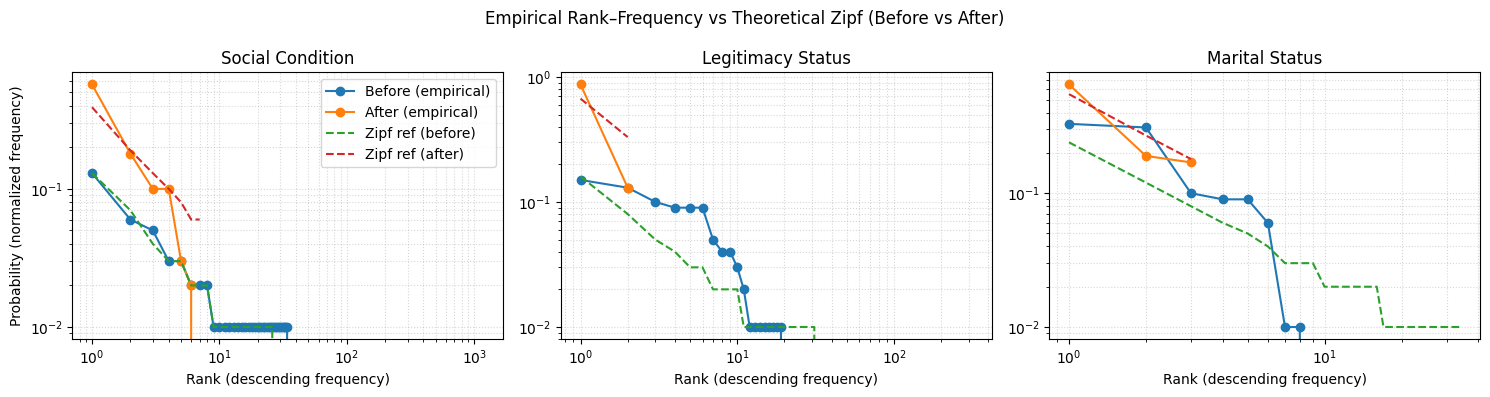

In [31]:
def get_series(df, cat, col):
    return df.loc[df['category'] == cat, col].iloc[0]

categories = stats_df['category'].tolist()
titles = [c.replace('_', ' ').title() for c in categories]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for ax, cat, title in zip(axes, categories, titles):
    # BEFORE
    z_before = get_series(stats_df, cat, 'zipf_distribution')
    e_before = get_series(stats_df, cat, 'empirical_ranks')

    # AFTER (normalized)
    z_after  = get_series(stats_normalized_df, cat, 'zipf_distribution')
    e_after  = get_series(stats_normalized_df, cat, 'empirical_ranks')

    # x = ranks (start at 1)
    xb = np.arange(1, len(e_before) + 1)
    xa = np.arange(1, len(e_after)  + 1)

    # empirical before/after
    ax.loglog(xb, e_before, marker='o', linestyle='-',  label='Before (empirical)')
    ax.loglog(xa, e_after,  marker='o', linestyle='-',  label='After (empirical)')

    # theoretical Zipf before/after (dashed)
    ax.loglog(xb, z_before, linestyle='--', label='Zipf ref (before)')
    ax.loglog(xa, z_after,  linestyle='--', label='Zipf ref (after)')

    ax.set_title(title)
    ax.set_xlabel("Rank (descending frequency)")
    ax.grid(True, which='both', linestyle=':', alpha=0.5)

axes[0].set_ylabel("Probability (normalized frequency)")
axes[0].legend()  # legend on first panel to save space
plt.suptitle("Empirical Rank–Frequency vs Theoretical Zipf (Before vs After)")
plt.tight_layout()
plt.show()

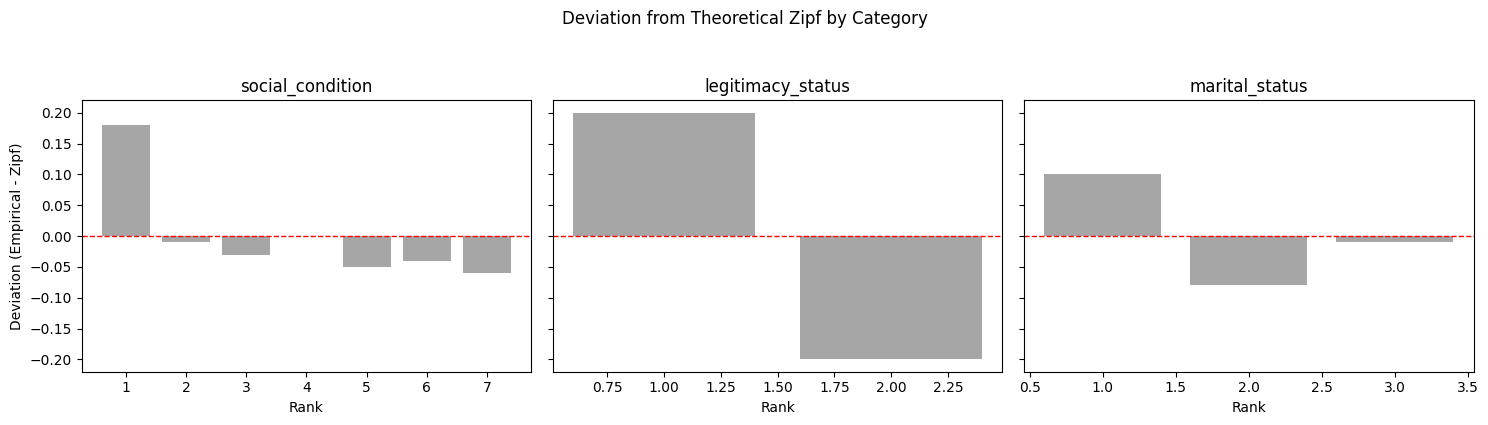

In [32]:
fig, axes = plt.subplots(1, len(categories), figsize=(15, 4), sharey=True)

for i, category in enumerate(categories):
    theoretical = stats_normalized_df.loc[stats_normalized_df['category'] == category, 'zipf_distribution'].iloc[0]
    empirical = stats_normalized_df.loc[stats_normalized_df['category'] == category, 'empirical_ranks'].iloc[0]

    deviation = np.array(empirical) - np.array(theoretical)
    
    axes[i].bar(range(1, len(theoretical) + 1), deviation, color='gray', alpha=0.7)
    axes[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[i].set_title(category)
    axes[i].set_xlabel("Rank")
    if i == 0:
        axes[i].set_ylabel("Deviation (Empirical - Zipf)")
    
plt.suptitle("Deviation from Theoretical Zipf by Category", y=1.05)
plt.tight_layout()
plt.show()

## Conclusion

The normalization process successfully compressed a large, noisy set of textual variations into a reduced, controlled vocabulary. Across all categories, the coefficient of variation decreased and normalized entropy increased, indicating greater term consistency and balance. The empirical rank–frequency curves moved closer to the theoretical Zipf distribution, showing reduced fragmentation and improved coherence in term usage.

Information loss was minimal — under 2% for legitimacy status and marital status, and about 13% for social condition, the most fragmented category prior to normalization. These changes substantially reduce noise and improve the dataset’s suitability for probabilistic record linkage.

Observed deviations from a perfect Zipfian distribution in legitimacy status and marital status are explained by their inherently small vocabularies (binary and three-term sets, respectively), rather than residual inconsistency. Future iterations could selectively expand controlled vocabularies if adding more dimensions proves beneficial for specific linkage scenarios.

## Resulting Data

The data produced during this analysis is stored in the `data/interim` directory for documentation and reproducibility purposes.

In [33]:
stats_df.to_csv("../data/interim/term_extraction_stats.csv", index=False)
stats_normalized_df.to_csv("../data/interim/term_extraction_stats_normalized.csv", index=False)